In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras
from keras.models import model_from_json
from skimage.transform import resize
import tensorflow as tf

Using TensorFlow backend.


In [2]:
dcm1 = pydicom.dcmread('test1.dcm')
dcm1

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       

In [3]:
# checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)       
    img = ds.pixel_array
    
    #age
    age = int(ds.PatientAge) 
    if age<1 or age>95:
        print(f'[INFO] Image {filename} rejected. Age: {age} is out of range.')
        return None
    
    #position
    position = ds.PatientPosition     
    if position not in ['PA', 'AP']:
       print(f'[INFO] Image {filename} rejected. Patient position: {position} is wrong.')
       return None   
    
    #body part
    body_part = ds.BodyPartExamined
    if body_part not in ['chest', 'CHEST']:
       print(f'[INFO] Image {filename} rejected. Body part: {position} is wrong.')
       return None             
              
    # Modality
    mol = ds.Modality
    if mol != 'DX':
       print(f'[INFO] Image {filename} rejected. Modality: {mol} is wrong.')
       return None 
    
    return img
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size): 
    img = resize(img, (img_size[1], img_size[2]), anti_aliasing=False)
    img = (img - img_mean)/img_std
    proc_img = img.reshape((1, img_size[1], img_size[2], 1))
    proc_img = np.repeat(proc_img, img_size[3], axis=3)

    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):   
    json_file = open(model_path, 'r')
    json_to_model = json_file.read()
    json_file.close()
    model = model_from_json(json_to_model)
    model.load_weights(weight_path)
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh):    
    result = model.predict(img)
    if result>thresh:
        prediction = 'Pneumonia'
    else:
        prediction = 'No Pneumonia'
        
    return prediction 

Load file test1.dcm ...
Load file test2.dcm ...
Load file test3.dcm ...
Load file test4.dcm ...
[INFO] Image test4.dcm rejected. Body part: PA is wrong.
Load file test5.dcm ...
[INFO] Image test5.dcm rejected. Modality: CT is wrong.
Load file test6.dcm ...
[INFO] Image test6.dcm rejected. Patient position: XX is wrong.


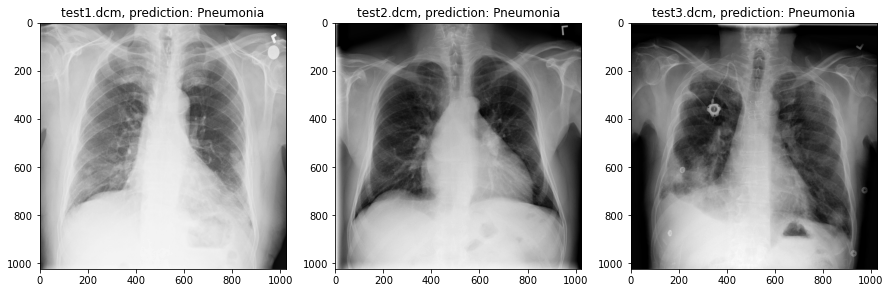

In [4]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'my_model.json' #path to saved model
weight_path = 'pneumonia_class_my_model.best.hdf5' #path to saved best weights

my_model = load_model(model_path, weight_path) #loads model 
thresh = 0.5 #loads the threshold chosen for model classification 

fig = plt.figure(figsize=(15,10))
# use the .dcm files to test the prediction
for num, filename in enumerate(test_dicoms) :
    
    img = np.array([])
    img = check_dicom(filename)
    
    if img is None:
        continue
     
    IMG_SIZE=(1,224,224,3) 
    img_mean = np.mean(img)
    img_std = np.std(img)
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
        
    ax = fig.add_subplot(2, 3, num+1)
    ax.set_title(f'{filename}, prediction: {pred}')
    plt.imshow(img, cmap='gray')
plt.show()
